In [75]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# Load dataset
df = pd.read_csv('data.csv')

In [77]:
# 1. Mengecek missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


In [78]:
# 2. Mengisi missing values
# Untuk data numerik: Mengisi dengan mean
numerical_features = ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity']
imputer_num = SimpleImputer(strategy='mean')
df[numerical_features] = imputer_num.fit_transform(df[numerical_features])

In [79]:
# Untuk data kategorikal: Mengisi dengan nilai terbanyak (mode)
categorical_features = ['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])

In [80]:
# 3. Mengatasi outliers
# Menggunakan metode IQR (Interquartile Range)
Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

In [81]:
# Menghapus data di luar rentang IQR
df_cleaned = df[~((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Data setelah menghapus outliers: {df_cleaned.shape}")


Data setelah menghapus outliers: (9548, 16)


In [82]:
# 4. Menghapus duplikat
df_cleaned = df_cleaned.drop_duplicates()
print(f"Data setelah menghapus duplikat: {df_cleaned.shape}")


Data setelah menghapus duplikat: (9081, 16)


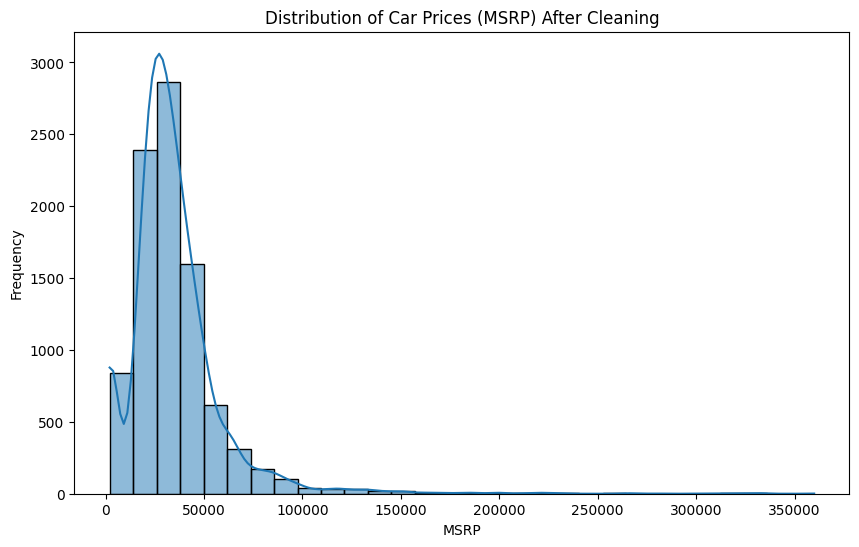

In [83]:
# 5. Visualisasi distribusi harga mobil (MSRP) setelah cleaning
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['MSRP'], bins=30, kde=True)
plt.title('Distribution of Car Prices (MSRP) After Cleaning')
plt.xlabel('MSRP')
plt.ylabel('Frequency')
plt.show()

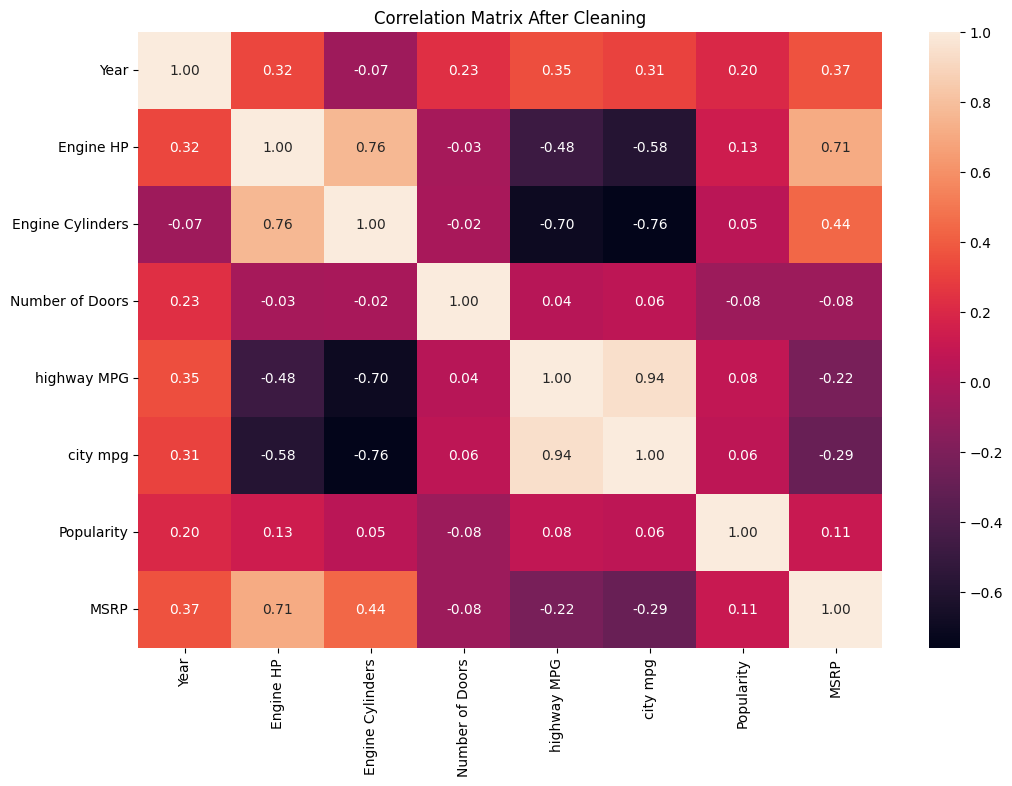

In [84]:
# 6. Korelasi fitur numerik setelah cleaning
plt.figure(figsize=(12, 8))
numeric_df_cleaned = df_cleaned.select_dtypes(include=[np.number])
sns.heatmap(numeric_df_cleaned.corr(), annot=True, fmt='.2f', color='blue')
plt.title('Correlation Matrix After Cleaning')
plt.show()

In [85]:
# Menghapus kolom yang tidak diperlukan
df_cleaned.drop(columns=['Make', 'Model', 'Vehicle Style', 'Market Category'], inplace=True)

In [86]:
# Memisahkan fitur dan label
X = df_cleaned.drop(columns=['MSRP'])
y = df_cleaned['MSRP']

In [87]:
# Fitur kategorikal dan numerik
categorical_features = ['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size']
numerical_features = ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity']

In [88]:
# Membuat preprocessing pipeline untuk data kategorikal dan numerik
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Mengisi NaN dengan rata-rata
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Mengisi NaN dengan nilai terbanyak
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [89]:
# Membagi dataset menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [90]:
# Membuat pipeline dengan preprocessing dan model regresi linier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [91]:
# Melatih model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Engine HP',
                                                   'Engine Cylinders',
                                                   'Number of Doors',
                                                   'highway MPG', 'city mpg',
                                                   'Popularity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Engine Fuel Type',
                                                   'Transmission Type',
                                                   'Driven_Wheels',
                                                   'Vehicle Size'])])),
                ('regressor', LinearRegression())])

In [92]:
# Prediksi pada data test
y_pred = model.predict(X_test)

In [93]:
# Evaluasi model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 8733.4837184031
R^2 Score: 0.6525505383880288


C:\Users\acer\AppData\Local\Temp\ipykernel_19912\4094703906.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, color='red')


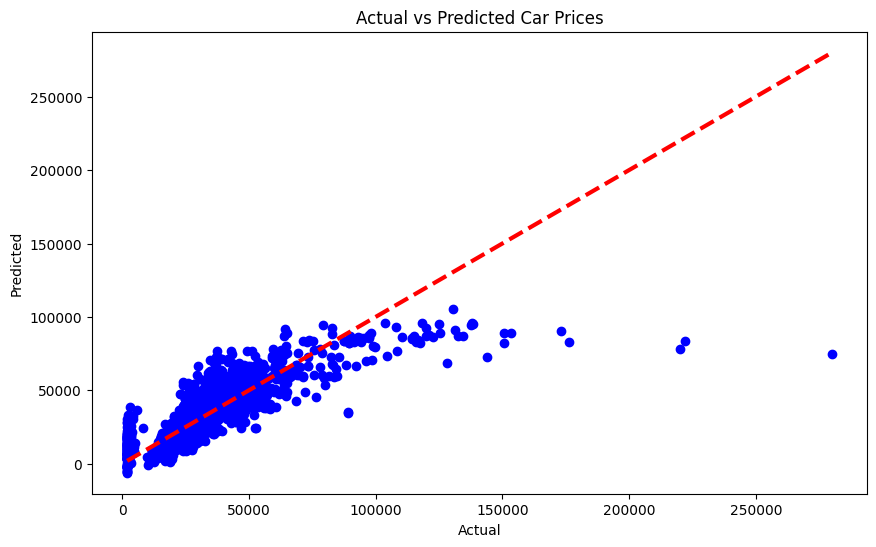

In [94]:
# Visualisasi prediksi vs harga asli
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Car Prices')
plt.show()

In [95]:
# Menyimpan model
joblib.dump(model, 'car_price_prediction_model.pkl')

['car_price_prediction_model.pkl']